# PackedSequence 와 PaddedSequence

[링크: PackedSequence에 대한 PyTorch 공식 문서](https://pytorch.org/docs/stable/nn.html#packedsequence)

이 튜토리얼에서는 RNN / LSTM 계열의 모델에서 sequence batch를 잘 활용할 수 있는 `PackedSequence` 와 `PaddedSequence`를 만드는 법을 배워보겠습니다.

PyTorch 라이브러리 안에는 다음 4가지 함수들이 주어집니다.

`pad_sequence`, `pack_sequence`, `pack_padded_sequence`, `pad_packed_sequence`

하지만 함수 이름만 봐서는 상당히 헷갈릴 수 있기 때문에 다음 그림을 참고하시면 이해하기 편하실 것 같습니다.

<img src="figures/sequence.png" alt="drawing" width="700"/>

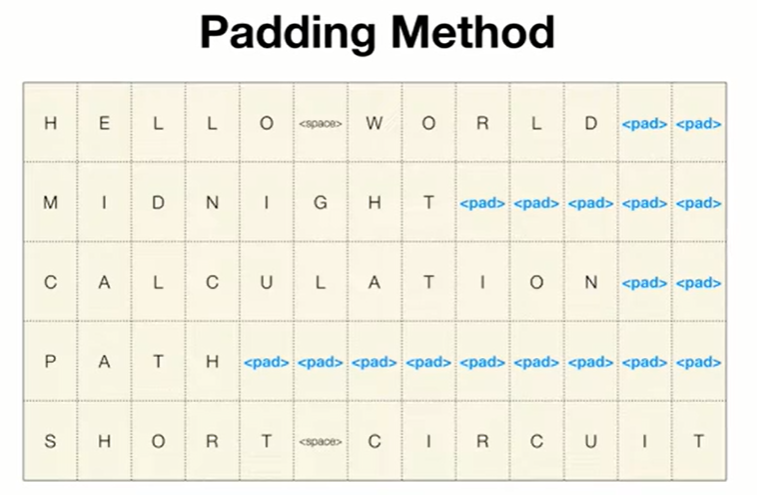

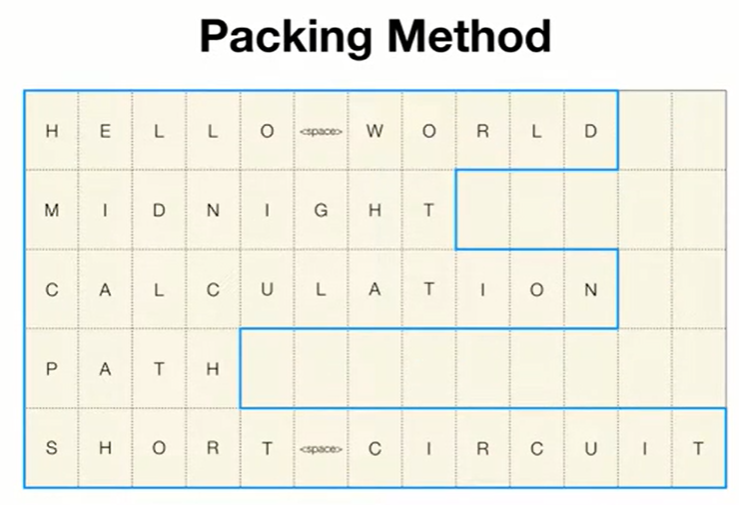

In [1]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence

## 예제 데이터

실습을 위해 간단한 예제 데이터를 만들었습니다.
여기서 잘 기억하셔야할 점은 batch size가 5이고, sequence 중 가장 긴 길이는 13라는 것 입니다.

In [2]:
# Random word from random word generator
data = ['hello world',
        'midnight',
        'calculation',
        'path',
        'short circuit']

# Make dictionary
char_set = ['<pad>'] + list(set(char for seq in data for char in seq)) # Get all characters and include pad token
char2idx = {char: idx for idx, char in enumerate(char_set)} # Constuct character to index dictionary
print('char_set:', char_set)
print('char_set length:', len(char_set))

char_set: ['<pad>', 'l', 'i', 'g', 't', 'c', 'u', 'o', 'e', 'w', 'n', 'h', 's', 'd', 'p', 'm', ' ', 'r', 'a']
char_set length: 19


In [3]:
# Convert character to index and make list of tensors
X = [torch.LongTensor([char2idx[char] for char in seq]) for seq in data]

# Check converted result
for sequence in X:
    print(sequence)

tensor([11,  8,  1,  1,  7, 16,  9,  7, 17,  1, 13])
tensor([15,  2, 13, 10,  2,  3, 11,  4])
tensor([ 5, 18,  1,  5,  6,  1, 18,  4,  2,  7, 10])
tensor([14, 18,  4, 11])
tensor([12, 11,  7, 17,  4, 16,  5,  2, 17,  5,  6,  2,  4])


다음과 같이 sequence의 길이가 제각각인 것을 확인하실 수 있습니다.

In [4]:
# Make length tensor (will be used later in 'pack_padded_sequence' function)
lengths = [len(seq) for seq in X]
print('lengths:', lengths)

lengths: [11, 8, 11, 4, 13]


# Sequence 데이터의 경우 어떻게 batch로 묶을까요?
위와같이 Text 나 audio 처럼 sequence 형식인 데이터의 경우 길이가 각각 다 다르기 때문에 

하나의 batch로 만들어주기 위해서 일반적으로 제일 긴 sequence 길이에 맞춰 뒷부분에 padding을 추가해줍니다.

이 방식이 일반적으로 많이 쓰이는 Padding 방식입니다.

하지만 PyTorch에서는 `PackedSequence`라는 것을 쓰면 padding 없이도 정확히 필요한 부분까지만 병렬 계산을 할 수 있습니다.

# `pad_sequence` 함수를 이용하여 PaddedSequence (그냥 Tensor) 만들기

사실, PaddedSequence는 sequence중에서 가장 긴 sequence와 길이를 맞추어주기 위해 padding을 추가한 일반적인 **Tensor**를 말합니다.

(따로 PaddedSequence라는 class는 존재하지 않습니다.)

이때, `pad_sequence`라는 PyTorch 기본 라이브러리 함수를 이용하면 쉽게 padding을 추가할 수 있습니다.

여기서 주의하실 점은 input이 **Tensor들의 list** 로 주어져야합니다. (그냥 **Tensor** 가 아닌 **Tensor들의 list** 입니다.)

list 안에 있는 각각의 Tensor들의 shape가 `(?, a, b, ...)` 라고 할때, (여기서 ?는 각각 다른 sequence length 입니다.)

`pad_sequence` 함수를 쓰면 `(T, batch_size, a, b, ...)` shape를 가지는 Tensor가 리턴됩니다. 
(여기서 `T`는 batch안에서 가장 큰 sequence length 입니다.)

만약, `pad_sequence`에 명시적으로 `batch_first=True`라는 파라미터를 지정해주면, 

`(batch_size, T, a, b, ...)` shape를 가지는 Tensor가 리턴됩니다. 

기본적으로 padding 값은 0으로 되어있지만, `padding_value=42`와 같이 파라미터를 지정해주면, padding하는 값도 정할 수 있습니다.

In [5]:
# Make a Tensor of shape (Batch x Maximum_Sequence_Length)
padded_sequence = pad_sequence(X, batch_first=True) # X is now padded sequence
print(padded_sequence)
print(padded_sequence.shape)

tensor([[11,  8,  1,  1,  7, 16,  9,  7, 17,  1, 13,  0,  0],
        [15,  2, 13, 10,  2,  3, 11,  4,  0,  0,  0,  0,  0],
        [ 5, 18,  1,  5,  6,  1, 18,  4,  2,  7, 10,  0,  0],
        [14, 18,  4, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 11,  7, 17,  4, 16,  5,  2, 17,  5,  6,  2,  4]])
torch.Size([5, 13])


# `pack_sequence` 함수를 이용하여 PackedSequence 만들기

PackedSequence는 위와같이 padding token을 추가하여 sequence의 최대 길이에 맞는 Tensor를 만드는게 아닌,

padding을 추가하지 않고 정확히 주어진 sequence 길이까지만 모델이 연산을 하게끔 만드는 PyTorch의 자료구조입니다.

이 PackedSequence를 만들기 위해서는 한가지 조건이 필요합니다.
- **주어지는 input (list of Tensor)는 길이에 따른 내림차순으로 정렬이 되어있어야 합니다.**

따라서 먼저 input을 길이에 따른 내림차순으로 정렬해봅시다.

In [6]:
# Sort by descending lengths
sorted_idx = sorted(range(len(lengths)), key=lengths.__getitem__, reverse=True)
sorted_X = [X[idx] for idx in sorted_idx]

# Check converted result
for sequence in sorted_X:
    print(sequence)

tensor([12, 11,  7, 17,  4, 16,  5,  2, 17,  5,  6,  2,  4])
tensor([11,  8,  1,  1,  7, 16,  9,  7, 17,  1, 13])
tensor([ 5, 18,  1,  5,  6,  1, 18,  4,  2,  7, 10])
tensor([15,  2, 13, 10,  2,  3, 11,  4])
tensor([14, 18,  4, 11])


자, 이제 input Tensor가 정렬되었으니 `pack_sequence`를 이용하여 PackedSequence를 만들어보겠습니다.

In [7]:
packed_sequence = pack_sequence(sorted_X)
print(packed_sequence)

PackedSequence(data=tensor([12, 11,  5, 15, 14, 11,  8, 18,  2, 18,  7,  1,  1, 13,  4, 17,  1,  5,
        10, 11,  4,  7,  6,  2, 16, 16,  1,  3,  5,  9, 18, 11,  2,  7,  4,  4,
        17, 17,  2,  5,  1,  7,  6, 13, 10,  2,  4]), batch_sizes=tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1]), sorted_indices=None, unsorted_indices=None)


# Embedding 적용해보기
자 이제, `PackedSequence`와 padding이 된 Tensor인 `PaddedSequence`를 만들어보았으니, RNN에 input으로 넣어서 테스트해보려고 합니다.

그 전에, 위에 예제들에서는 input이 character의 index들을 가지고 있는 데이터였지만, 보통은 주로 이를 embedding한 값을 RNN의 input으로 넣어줍니다.

이 튜토리얼에서는 one-hot character embedding을 해보도록 하겠습니다.

In [8]:
# one-hot embedding using PaddedSequence
eye = torch.eye(len(char_set)) # Identity matrix of shape (len(char_set), len(char_set))
embedded_tensor = eye[padded_sequence]
print(embedded_tensor.shape) # shape: (Batch_size, max_sequence_length, number_of_input_tokens)

torch.Size([5, 13, 19])


In [9]:
# one-hot embedding using PackedSequence
embedded_packed_seq = pack_sequence([eye[X[idx]] for idx in sorted_idx])
print(embedded_packed_seq.data.shape)

torch.Size([47, 19])


# RNN 모델 만들기
간단한 RNN 모델을 한번 만들어봅시다.

In [10]:
# declare RNN
rnn = torch.nn.RNN(input_size=len(char_set), hidden_size=30, batch_first=True)

`PaddedSequence`를 이용하여 RNN에 넣어봅시다.

In [11]:
rnn_output, hidden = rnn(embedded_tensor)
print(rnn_output.shape) # shape: (batch_size, max_seq_length, hidden_size)
print(hidden.shape)     # shape: (num_layers * num_directions, batch_size, hidden_size)

torch.Size([5, 13, 30])
torch.Size([1, 5, 30])


`PackedSequence`를 이용하여 RNN에 넣어봅시다.

In [12]:
rnn_output, hidden = rnn(embedded_packed_seq)
print(rnn_output.data.shape)
print(hidden.data.shape)

torch.Size([47, 30])
torch.Size([1, 5, 30])


# `pad_packed_sequence`

위 함수는 `PackedSequence`를 `PaddedSequence`(Tensor)로 바꾸어주는 함수입니다.

`PackedSequence`는 각 sequence에 대한 길이 정보도 가지고있기 때문에, 이 함수는 Tensor와 함께 길이에 대한 리스트를 튜플로 리턴해줍니다.

리턴값: (Tensor, list_of_lengths)

In [13]:
unpacked_sequence, seq_lengths = pad_packed_sequence(embedded_packed_seq, batch_first=True)
print(unpacked_sequence.shape)
print(seq_lengths)

torch.Size([5, 13, 19])
tensor([13, 11, 11,  8,  4])


# `pack_padded_sequence`
반대로, Padding이 된 Tensor인 `PaddedSequence`를 `PackedSequence`로 바꾸어주는 함수도 있습니다.

`pack_padded_sequence` 함수는 실제 sequence길이에 대한 정보를 모르기때문에, 파라미터로 꼭 제공해주어야합니다.

여기서 주의하여야 할 점은, input인 `PaddedSequence`가 아까 언급드린 **길이에 따른 내림차순으로 정렬되어야 한다는** 조건이 성립되어야 `PackedSequence`로 올바르게 변환될 수 있습니다.

아까 저희가 만든 `padded_sequence` 변수는 이 조건을 만족하지 않기 때문에 다시 새로 만들어보겠습니다.

In [14]:
embedded_padded_sequence = eye[pad_sequence(sorted_X, batch_first=True)]
print(embedded_padded_sequence.shape)

torch.Size([5, 13, 19])


이제 이 padding이 된 Tensor를 `PackedSequence`로 변환해보겠습니다.

In [15]:
sorted_lengths = sorted(lengths, reverse=True)
new_packed_sequence = pack_padded_sequence(embedded_padded_sequence, sorted_lengths, batch_first=True)
print(new_packed_sequence.data.shape)
print(new_packed_sequence.batch_sizes)

torch.Size([47, 19])
tensor([5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 1, 1])
